In [1]:
#from google.colab import drive
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from os import sys
from math import *
import plotly_express as px

from pingouin import *
import statsmodels.formula.api as sm

import pandas as pd

In [2]:
dfe = pd.read_csv("C:\Pablo\datasets\\household_power_consumption.txt", delimiter=";", low_memory=False)

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
dfe['date_time'] = pd.to_datetime(dfe['Date'] + ' ' + dfe['Time'])
dfe.replace(to_replace='?',value=np.nan,inplace=True)
dfe.dropna(subset=['Sub_metering_3'],inplace=True)
for i in dfe.columns:
    print(f'{i.capitalize()} tiene {pd.isna(dfe[i]).sum()} valores nulos')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_17780\1618814546.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dfe['date_time'] = pd.to_datetime(dfe['Date'] + ' ' + dfe['Time'])


Date tiene 0 valores nulos
Time tiene 0 valores nulos
Global_active_power tiene 0 valores nulos
Global_reactive_power tiene 0 valores nulos
Voltage tiene 0 valores nulos
Global_intensity tiene 0 valores nulos
Sub_metering_1 tiene 0 valores nulos
Sub_metering_2 tiene 0 valores nulos
Sub_metering_3 tiene 0 valores nulos
Date_time tiene 0 valores nulos


In [4]:
def flotante(string):
    try:
        return float(string)
    except:
        return float(0)

float_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in float_cols:
    dfe[col] = dfe[col].apply(lambda x: flotante(x))

In [5]:
pag = dfe.Global_active_power*1000
prg = dfe.Global_reactive_power*1000
pa = (pag**2)+(prg**2)
pa = pa.apply(lambda x: sqrt(x))
dfe.insert(loc=4,column='apparent_power',value=pa)

pf = (dfe.Global_active_power/(dfe.apparent_power/1000))
dfe.insert(loc=4,column='power_factor',value=pf)

imp = (dfe.Voltage/dfe.Global_intensity)
dfe.insert(loc=5,column='impedance',value=imp)

angulo_fase = dfe.power_factor.values
angulo = []
angulo_radianes = 180/np.pi
for x in angulo_fase:
    angulo.append((acos(x)*angulo_radianes))
angulo = pd.Series(angulo)
dfe.insert(loc=5,column='phase_angle',value=angulo)

In [6]:
dfe_h = dfe.drop(['Date','Time'],axis=1)
dfe_h['hour'] = dfe_h['date_time'].apply(lambda x: x.hour)
dfe_h = dfe_h.resample('H',on='date_time').sum()


In [7]:
dfe_h['Voltage'] = dfe_h['Voltage']/60

In [8]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)

    return result

Para la variable potencia activa se usaran instancias por hora, y para la variable factor de potencia se usaran instancias por minuto.

In [9]:
dfe_norm_ap = normalize(dfe_h[['Global_active_power','power_factor','impedance','Sub_metering_1','Sub_metering_2','Sub_metering_3']])
dfe_norm_pf = normalize(dfe[['Global_active_power','apparent_power','power_factor','impedance','Sub_metering_1','Sub_metering_2','Sub_metering_3']])

In [10]:
model1 = 'Global_active_power~Global_reactive_power+impedance+power_factor+Voltage+Sub_metering_3+Sub_metering_1+Sub_metering_2'
lm1 = sm.ols(formula= model1,data=dfe_h).fit()
print(lm1.summary())

                             OLS Regression Results                            
Dep. Variable:     Global_active_power   R-squared:                       0.818
Model:                             OLS   Adj. R-squared:                  0.818
Method:                  Least Squares   F-statistic:                 2.221e+04
Date:                 Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                         09:38:35   Log-Likelihood:            -1.5758e+05
No. Observations:                34589   AIC:                         3.152e+05
Df Residuals:                    34581   BIC:                         3.152e+05
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Se aplicaron las siguientes lineas en el dataframe normalizado que excluye algunas columnas
# En la variable X separamos las demas columnas de la objetivo que en este caso es la variable y, que hace ademas referencia a la energia activa total.
X = dfe_norm_ap.drop('Global_active_power', axis=1)
y = dfe_norm_ap['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()

In [12]:
# Selección de predictores con sklearn SequentialFeatureSelector
# ==============================================================================
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
sfs = SequentialFeatureSelector(
    modelo,
    n_features_to_select = 'auto',
    direction            = 'forward',
    scoring              = 'neg_mean_poisson_deviance',  # r2, max_error, explained_variance
    cv                   = 5
)
sfs.fit(X_train, y_train)
sfs.get_feature_names_out().tolist()

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pablo\AppData\Local\Programs\Python\Pytho

['power_factor', 'impedance']

Del metodo de seleccion de predictores de sklearn, SequentialFeatureSelector.

Siguiendo una estrategia de selección secuencial basada en el  R2 (scoring='r2')y con validación cruzada de 5 particiones(cv=5), los predictores seleccionados son: 'Global_active_power', 'Global_reactive_power' y 'apparent_power' despues de una normalizacion

Mejor R cuadrado para factor de potencia: Impedancia y Voltaje

Mejor R cuadrado y precision para energia activa : power_factor, impedancia y potencia aparente

Mean Squared Error: 0.003666165393532457


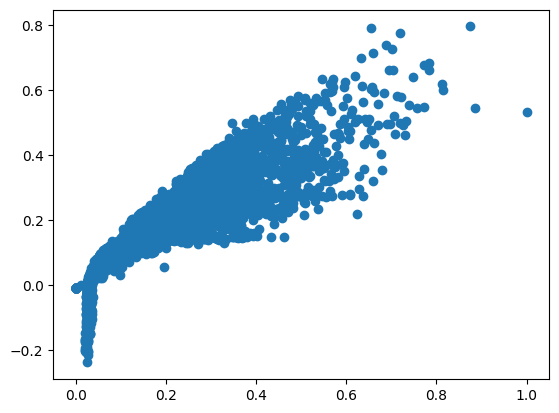

In [13]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
error_cuadrado = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {error_cuadrado}')

plt.scatter(y_test, predictions)
plt.show()

## Prediccion de las ultimas 50 horas de la variable energia activa
**Energia activa**

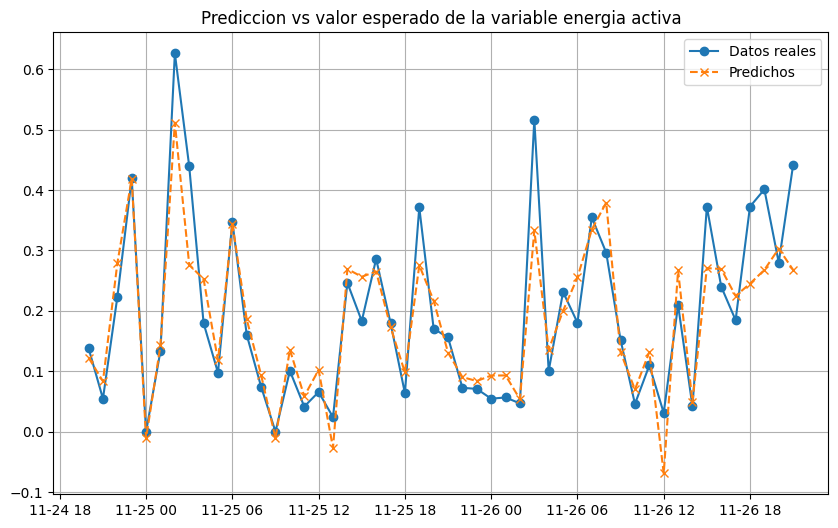

In [14]:
plt.figure(figsize=(10,6))
plt.plot(dfe_h.index[-50:], y_test[-50:], label='Datos reales', marker='o')
plt.plot(dfe_h.index[-50:], predictions[-50:], label='Predichos', marker='x',linestyle='--')
plt.title('Prediccion vs valor esperado de la variable energia activa')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# grafico interactivo
y_test = pd.array(y_test)
datos_plot = pd.DataFrame({
    'test': y_test[-1000:],
    'prediccion':predictions[-1000:],
})

datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500,
    markers= True
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**Factor de potencia**

In [16]:
K = dfe_norm_pf.drop('power_factor', axis=1)
z = dfe_norm_pf['power_factor']

X_train, X_test, y_train, y_test = train_test_split(K, z, test_size=0.2, random_state=42)
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
predictions = model_2.predict(X_test)
error_cuadrado = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {error_cuadrado}')

Mean Squared Error: 0.0031883650294967586


## Prediccion del factor de potencia durante la ultima hora de registro

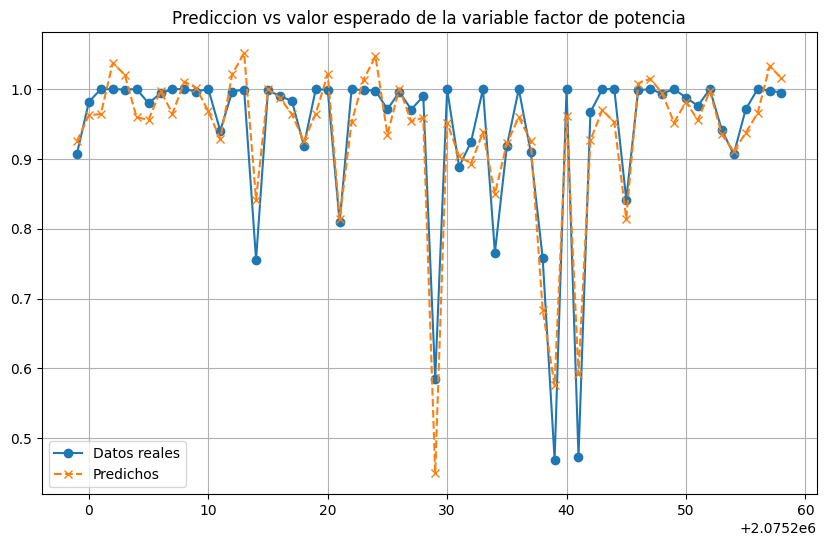

In [17]:
plt.figure(figsize=(10,6))
plt.plot(dfe.index[-60:], y_test[-60:], label='Datos reales', marker='o')
plt.plot(dfe.index[-60:], predictions[-60:], label='Predichos', marker='x',linestyle='--')
plt.legend()
plt.title('Prediccion vs valor esperado de la variable factor de potencia')
plt.grid(True)
plt.show()

**Analisis en profundidad**
Calculos de los p-valores para el test de Beta

In [18]:
p_values = lm1.pvalues
print(p_values)

Intercept                0.062266
Global_reactive_power    0.000000
impedance                0.000000
power_factor             0.000000
Voltage                  0.000000
Sub_metering_3           0.000000
Sub_metering_1           0.000000
Sub_metering_2           0.000000
dtype: float64


In [19]:
y_test = pd.array(y_test)

## Grafico interactivo para predicciones de la energia activa

In [20]:
# grafico interactivo
datos_plot = pd.DataFrame({
    'test': y_test[-1000:],
    'prediccion':predictions[-1000:],
})

datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500,
    markers= True
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**Tener en cuenta**

Las variables de python, con los datos de entrenamiento y test (X_train, X_test, y_train, y_test) primero son utilizadas para predecir a la energia activa y luego son reasignadas para los valores del factor de potencia. 

In [24]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
error_cuadrado = mean_squared_error(y_test, predictions)
print(f'error cuadrático medio: {error_cuadrado}')
rmse = np.sqrt(error_cuadrado)
print("Raíz del error cuadrático medio (Root Mean Squared Error, RMSE)",rmse)

mae = mean_absolute_error(y_test, predictions)
print("Raíz del error absoluto medio ( Mean Absolute Error, RMSE)",mae)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_valor = mape(y_test, predictions)
print("MAPE (Error Porcentual Absoluto Medio):", mape_valor)

r2 = r2_score(y_test, predictions)
print("Coeficiente de determinación (R²):", r2)

error cuadrático medio: 0.0031883650294967586
Raíz del error cuadrático medio (Root Mean Squared Error, RMSE) 0.05646560926348673
Raíz del error absoluto medio ( Mean Absolute Error, RMSE) 0.03613842701539003
MAPE (Error Porcentual Absoluto Medio): 4.662577583682498
Coeficiente de determinación (R²): 0.8145787888173717


In [26]:
model_2.coef_

array([ 4.62638763e+01, -4.59955908e+01, -7.88177895e-02, -1.03724055e-01,
       -8.99851703e-02,  1.07979398e-02])

In [28]:
model_2.intercept_

0.9758902879835802

Formula:

Intercepto del modelo: Ordenada al origen

Coeficiente del modelo: pendiente

In [32]:
df_coef = pd.DataFrame(model_2.coef_, K.columns,columns =['Coeficientes'])
df_coef

,Coeficientes
Global_active_power,46.263876
apparent_power,-45.995591
impedance,-0.078818
Sub_metering_1,-0.103724
Sub_metering_2,-0.089985
Sub_metering_3,0.010798
